<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/TransformerV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import requests
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
raw_text = requests.get(url).text

In [17]:
train_amount = 0.9
train_text, val_text = raw_text[:int(len(raw_text) * train_amount)], raw_text[int(len(raw_text) * train_amount):]
train_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [18]:
vocab = set(raw_text)
vocab.add("<|UNK|>")
vocab = sorted(vocab)

stoi = {char:i for i, char in enumerate(vocab)}
itos = {i:char for i, char in enumerate(stoi)}
itos[stoi['<|UNK|>']]

'<|UNK|>'

In [19]:
class Tokenizer:
  def __init__(self, stoi, itos):
    self.stoi = stoi
    self.itos = itos
  def __len__(self):
    return len(self.stoi) - 1
  def encode(self, text):
    return [stoi.get(char, stoi['<|UNK|>']) for char in text]
  def decode(self, tokens):
    return "".join([itos.get(token, '<|UNK|>') for token in tokens])
tokenizer = Tokenizer(stoi, itos)
tokenizer.decode(tokenizer.encode("hello world ^}|%"))

'hello world <|UNK|><|UNK|><|UNK|><|UNK|>'

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

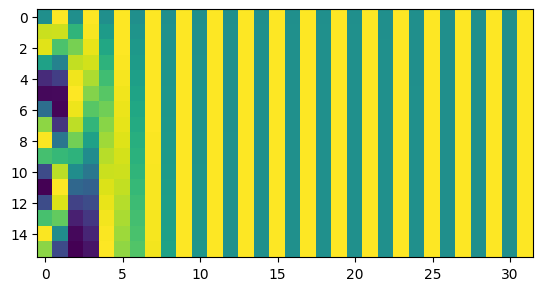

In [21]:
max_seq_len = 16
emb_dim = 32
import math
def create_positional_encoding_matrix(max_seq_len, emb_dim):
  mask = torch.zeros((max_seq_len, emb_dim))
  for pos in range(max_seq_len):
    for i in range(0, emb_dim, 2):
      mask[pos, i] = math.sin(pos/(10000 ** ((2*i)/emb_dim)))
      mask[pos, i+1] = math.cos(pos/(10000 ** ((2*(i+1))/emb_dim)))
  return mask
positional_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim)
import matplotlib.pyplot as plt
plt.imshow(positional_encoding_matrix.numpy())

In [22]:
class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, n_heads, emb_dim, dropout=0.1):
    super().__init__()
    assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by head number"
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.head_size = emb_dim // n_heads
    self.wq = nn.Linear(emb_dim, emb_dim)
    self.wk = nn.Linear(emb_dim, emb_dim)
    self.wv = nn.Linear(emb_dim, emb_dim)

    self.wo = nn.Linear(emb_dim, emb_dim)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    batch_size, seq_len, emb_dim = x.size()
    Q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    K = self.wk(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    V = self.wv(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)

    scaled_dot_product = (torch.matmul(Q, K.transpose(2, 3)))/(self.head_size**0.5)

    attn_mask = torch.triu(
        torch.ones(seq_len, seq_len),
        diagonal=1
    ).to(device)
    attn_mask.masked_fill_(attn_mask==1, float('-inf'))

    scaled_dot_product += attn_mask

    attn_scores = torch.matmul(F.softmax(scaled_dot_product, dim=-1), V)
    attn_scores = attn_scores.view(batch_size, -1, self.n_heads * self.head_size)
    attn_scores = self.dropout(attn_scores)
    out = self.wo(attn_scores)

    return out # (batch_size, seq_len, emb_dim)


In [23]:
class MLP(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.l1 = nn.Linear(in_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, out_size)
    self.act = nn.GELU()
  def forward(self, ins):
    hidden = self.act(self.l1(ins))
    return self.act(self.l2(hidden))

In [24]:
class TransformerBlock(nn.Module):
  def __init__(self, n_heads, emb_dim, dropout=0.1):
    super().__init__()
    self.layernorm = nn.LayerNorm(emb_dim)
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.MHA = MaskedMultiHeadAttention(n_heads, emb_dim, dropout=dropout)
    self.post_attention_dropout = nn.Dropout(dropout)
    self.MLP = MLP(emb_dim, emb_dim * 4, emb_dim)
    self.post_MLP_dropout = nn.Dropout(dropout)
  def forward(self, ins):
    residual = ins.clone()
    ins = self.layernorm(ins)
    ins = self.MHA(ins)
    ins = self.post_attention_dropout(ins)
    ins += residual

    residual2 = ins.clone()
    ins = self.layernorm(ins)
    ins = self.MLP(ins)
    ins = self.post_MLP_dropout(ins)
    ins += residual2
    return ins


In [25]:
class GPT(nn.Module):
  def __init__(self, n_heads, emb_dim, max_seq_len, n_blocks, tokenizer, dropout=0.1):
    super().__init__()
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.max_seq_len = max_seq_len
    self.n_blocks = n_blocks
    self.tokenizer = tokenizer
    self.layernorm = nn.LayerNorm(emb_dim)
    self.emb = nn.Embedding(len(tokenizer) + 1, emb_dim)
    self.pos_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim).to(device)
    self.decoder_stack = nn.ModuleList([
        TransformerBlock(n_heads, emb_dim, dropout=dropout)
        for _ in range(n_blocks)
    ])

    self.logits_layer = nn.Linear(emb_dim, len(tokenizer)+1)
  def forward(self, ins):
    embedding = self.emb(ins)
    pos_encoding_indices = torch.arange(ins.shape[1]).to(device) # seq_len

    x = embedding
    x += self.pos_encoding_matrix[pos_encoding_indices]

    for decoder in self.decoder_stack:
      x = decoder(x)

    x = self.layernorm(x)
    logits = self.logits_layer(x)
    return logits
  @torch.no_grad()
  def generate(self, text, length=10):
    out = ""
    for x in range(length):
      encodings = torch.tensor(self.tokenizer.encode(text + out)).to(device)
      seq_len = len(encodings)
      if seq_len > self.max_seq_len:
        encodings = encodings[len(encodings) - self.max_seq_len:]
      tokens = encodings.view(1, -1)
      logits = self.forward(tokens)[0, -1, :] # logits for last char
      probs = F.softmax(logits, dim=-1)
      selection_index = torch.multinomial(probs, num_samples=1)
      out += self.tokenizer.decode([selection_index.item()])
    return out

In [35]:
max_seq_len = 256
emb_dim = 384
n_heads = 6
n_blocks = 6
dropout = 0.25

lr = 0.001
batch_size = 8
max_steps = 2001

log_period = 50
val_interval = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


myGPT = GPT(n_heads, emb_dim, max_seq_len, n_blocks, tokenizer, dropout=dropout)
myGPT = myGPT.to(device)
print("Total params:", sum(p.numel() for p in myGPT.parameters()))
if torch.cuda.is_available():
  myGPT = torch.compile(myGPT)
optim = torch.optim.AdamW(myGPT.parameters(), lr=lr)

Total params: 10693698


In [27]:
def generate_dataset(max_seq_len, tokens):
  context_x = tokens[:max_seq_len]
  context_y = tokens[1:max_seq_len+1]
  x_examples = [context_x]
  y_examples = [context_y]
  for token, next in zip(tokens[max_seq_len:], tokens[max_seq_len+1:]):
    context_x = context_x[1:]
    context_x.append(token)
    context_y = context_y[1:]
    context_y.append(next)
    x_examples.append(context_x)
    y_examples.append(context_y)
  return torch.tensor(x_examples).long().to(device), torch.tensor(y_examples).to(device)
tokenized_train_data = tokenizer.encode(train_text)
Xtr, Ytr = generate_dataset(max_seq_len, tokenized_train_data)
tokenized_test_data = tokenizer.encode(val_text)
Xte, Yte = generate_dataset(max_seq_len, tokenized_test_data)
tokenizer.decode(Xtr[0].cpu().numpy()), tokenizer.decode(Ytr[0].cpu().numpy())

('First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\n',
 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nW')

In [36]:
train_len = len(Xtr) - 1
best_val_loss = float('inf')
import time
for step in range(max_steps):
  step_start = time.time()
  batch_indices = torch.randint(0, train_len, (batch_size,)).to(device)
  x_batch = Xtr[batch_indices]
  y_batch = Ytr[batch_indices].view(-1)

  logits = myGPT(x_batch)
  logits = logits.view(-1, logits.size(-1))
  loss = F.cross_entropy(logits, y_batch)
  optim.zero_grad()
  loss.backward()
  optim.step()

  if step % log_period == 0:
    with torch.no_grad():
      if step % val_interval == 0:
        validation_loss = 0
        for _ in range(len(Xte)//batch_size):
          batch_indices = torch.randint(0, len(Xte), (batch_size,)).to(device)
          x_batch = Xte[batch_indices]
          y_batch = Yte[batch_indices].view(-1)
          gpt_predictions = myGPT(x_batch)
          gpt_predictions = gpt_predictions.view(-1, gpt_predictions.size(-1))
          current_loss = F.cross_entropy(gpt_predictions, y_batch.view(-1))
          validation_loss += current_loss
        validation_loss /= len(Xte)//batch_size
        if validation_loss < best_val_loss:
          best_val_loss = validation_loss
          torch.save(myGPT.state_dict(), "best_model.pt")
        print("Step", str(step) + ", val loss:", validation_loss.item())
    step_end = time.time()
    step_time = step_end - step_start
    print(f"Step {step} ({step_time * 1e3} ms: loss {loss.item()})")
print("Loading best model")
myGPT.load_state_dict(torch.load("best_model.pt"))

Step 0, val loss: 3.4984593391418457
Step 0 (286574.8918056488 ms: loss 4.404128551483154)
Step 50 (51.773786544799805 ms: loss 2.525001049041748)
Step 100 (50.72021484375 ms: loss 2.579176187515259)
Step 150 (50.60386657714844 ms: loss 2.507404088973999)
Step 200 (48.41423034667969 ms: loss 2.3467252254486084)
Step 250 (49.44133758544922 ms: loss 2.04978084564209)
Step 300 (53.29179763793945 ms: loss 1.5433398485183716)
Step 350 (50.11105537414551 ms: loss 1.3528873920440674)
Step 400 (59.16166305541992 ms: loss 1.2884275913238525)
Step 450 (55.155038833618164 ms: loss 1.26047945022583)
Step 500, val loss: 1.2518144845962524
Step 500 (242969.34342384338 ms: loss 1.2306936979293823)
Step 550 (51.078081130981445 ms: loss 1.2474048137664795)
Step 600 (50.56881904602051 ms: loss 1.222843050956726)
Step 650 (51.57876014709473 ms: loss 1.2023743391036987)
Step 700 (51.38349533081055 ms: loss 1.221926212310791)
Step 750 (52.72507667541504 ms: loss 1.2199162244796753)
Step 800 (60.79626083374

<All keys matched successfully>

In [37]:
print(myGPT.generate("\n", length=500))


bl's bicaledyovintve gale o lde ser wabu haire y ceand hen haveme tounghthethenentivete te t ulece whe cceathen' thenth he wnceetheethe tee theetheveve t hit te hle Itha tche tot cend toncthineane:
Wht,
Wh!
Whe f theete netom s, thewhe methe, t thanervent qut. thtom thithy t
Catout ovy, f foungr;
Myor,-favas ssse s ckerthereacenensesenerexceverthexngrint ke
THet.
BRCHAD ESick?
Whot
KIZI


COUCOLLANEDYFF t.

TUCKINCKELICKI C

HIURDWIOWBUKING VINUCLABESRD HELIULI:
BRDONUMING KICY IFWh.
QUCHADWh. 
